<a href="https://colab.research.google.com/github/tashir0605/SentimentSphere/blob/main/Human_Emotion_through_Visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the dataset zip file
uploaded = files.upload()

# Unzip the dataset
zip_path = list(uploaded.keys())[0]  # Get the uploaded file name
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('fer2013')

# Verify the dataset structure
print("Dataset extracted to 'fer2013' directory.")
print(os.listdir('fer2013'))

Saving fer2013.zip to fer2013.zip
Dataset extracted to 'fer2013' directory.
['fer2013']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = '/content/fer2013/fer2013/train'
test_dir = '/content/fer2013/fer2013/test'

# Image dimensions and batch size
img_size = (48, 48)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=15,  # Random rotation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.2  # Split 20% of training data for validation
)

# No augmentation for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep test data in order for evaluation
)

# Check class indices
print("Class Indices:", train_generator.class_indices)

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class Indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


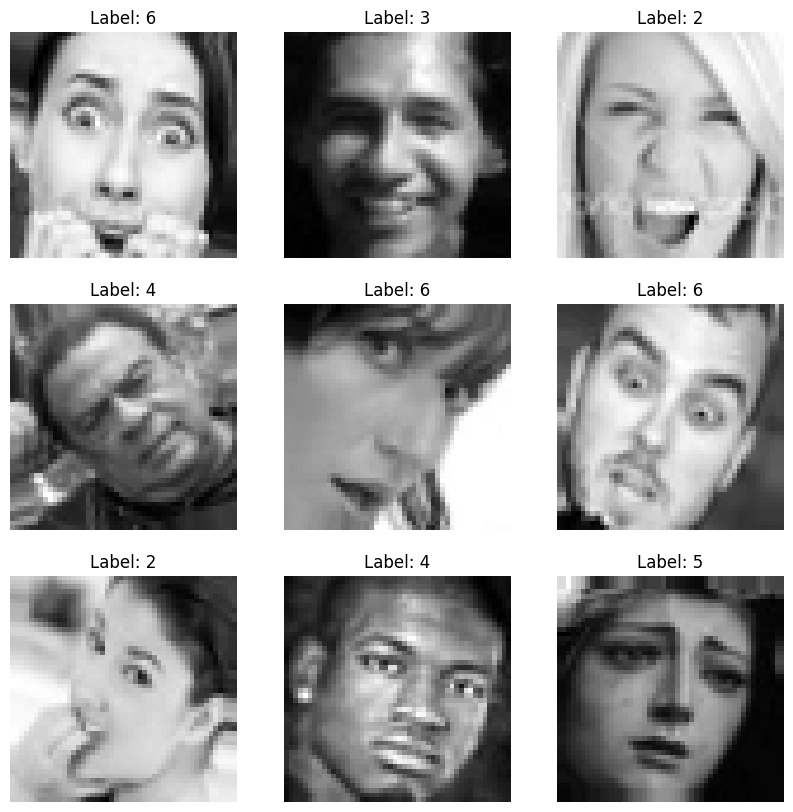

In [ ]:
import matplotlib.pyplot as plt

# Display a batch of images
def show_batch(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].argmax()}")
        plt.axis('off')
    plt.show()

# Show a batch of training images
show_batch(train_generator)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer (7 emotions)
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Get the class labels from the training generator
train_labels = train_generator.classes

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',  # Use 'balanced' to automatically adjust weights
    classes=np.unique(train_labels),  # Unique classes in the dataset
    y=train_labels  # Actual labels
)

# Convert class_weights to a dictionary (required by Keras)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.031075340934496, 1: 9.439214081047892, 2: 1.0034376223837083, 3: 0.574718373043565, 4: 0.8264640527560748, 5: 0.8337852984777814, 6: 1.2848228214842878}


In [ ]:
history = model.fit(
    train_generator,  # Use `train_datagen.flow()` if augmenting data
    epochs=50,
    validation_data=val_generator,  # Changed from val_data to val_generator
    class_weight=class_weights  # Optional: Handle class imbalance
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.1199 - loss: 1.9581 - val_accuracy: 0.1744 - val_loss: 1.9314
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.1274 - loss: 1.9343 - val_accuracy: 0.1307 - val_loss: 1.9438
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.1482 - loss: 1.9119 - val_accuracy: 0.2104 - val_loss: 1.8491
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.2297 - loss: 1.8363 - val_accuracy: 0.3013 - val_loss: 1.7999
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.2648 - loss: 1.7978 - val_accuracy: 0.2814 - val_loss: 1.7613
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.2946 - loss: 1.7569 - val_accuracy: 0.3400 - val_loss: 1.6843
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.3155 - loss: 1.7052 - val_accuracy: 0.3032 - val_loss: 1.7167
Epoch 8/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.3192 - loss: 1.6986 - val_accurac

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model.save('fer2013_emotion_model.h5')
print("Model saved to 'fer2013_emotion_model.h5'")

Model saved to 'fer2013_emotion_model.h5'


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3970 - loss: 1.4407
Test Loss: 1.3167
Test Accuracy: 0.4966


In [ ]:
# Get predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get true labels
true_labels = test_generator.classes

# Class indices mapping (to convert numeric labels to emotion names)
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Print some predictions
for i in range(10):  # Display first 10 predictions
    print(f"Image {i + 1}:")
    print(f"  Predicted: {class_names[predicted_labels[i]]} ({predicted_labels[i]})")
    print(f"  True: {class_names[true_labels[i]]} ({true_labels[i]})")
    print()

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Image 1:
  Predicted: neutral (4)
  True: angry (0)

Image 2:
  Predicted: surprise (6)
  True: angry (0)

Image 3:
  Predicted: disgust (1)
  True: angry (0)

Image 4:
  Predicted: angry (0)
  True: angry (0)

Image 5:
  Predicted: angry (0)
  True: angry (0)

Image 6:
  Predicted: angry (0)
  True: angry (0)

Image 7:
  Predicted: happy (3)
  True: angry (0)

Image 8:
  Predicted: sad (5)
  True: angry (0)

Image 9:
  Predicted: disgust (1)
  True: angry (0)

Image 10:
  Predicted: disgust (1)
  True: angry (0)



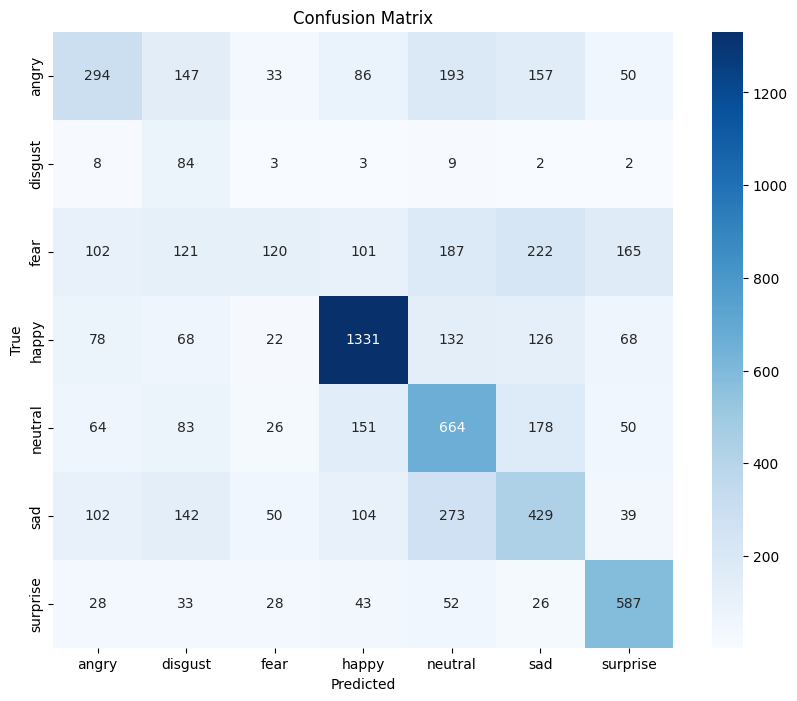

Classification Report:
              precision    recall  f1-score   support

       angry       0.43      0.31      0.36       960
     disgust       0.12      0.76      0.21       111
        fear       0.43      0.12      0.18      1018
       happy       0.73      0.73      0.73      1825
     neutral       0.44      0.55      0.49      1216
         sad       0.38      0.38      0.38      1139
    surprise       0.61      0.74      0.67       797

    accuracy                           0.50      7066
   macro avg       0.45      0.51      0.43      7066
weighted avg       0.52      0.50      0.49      7066



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


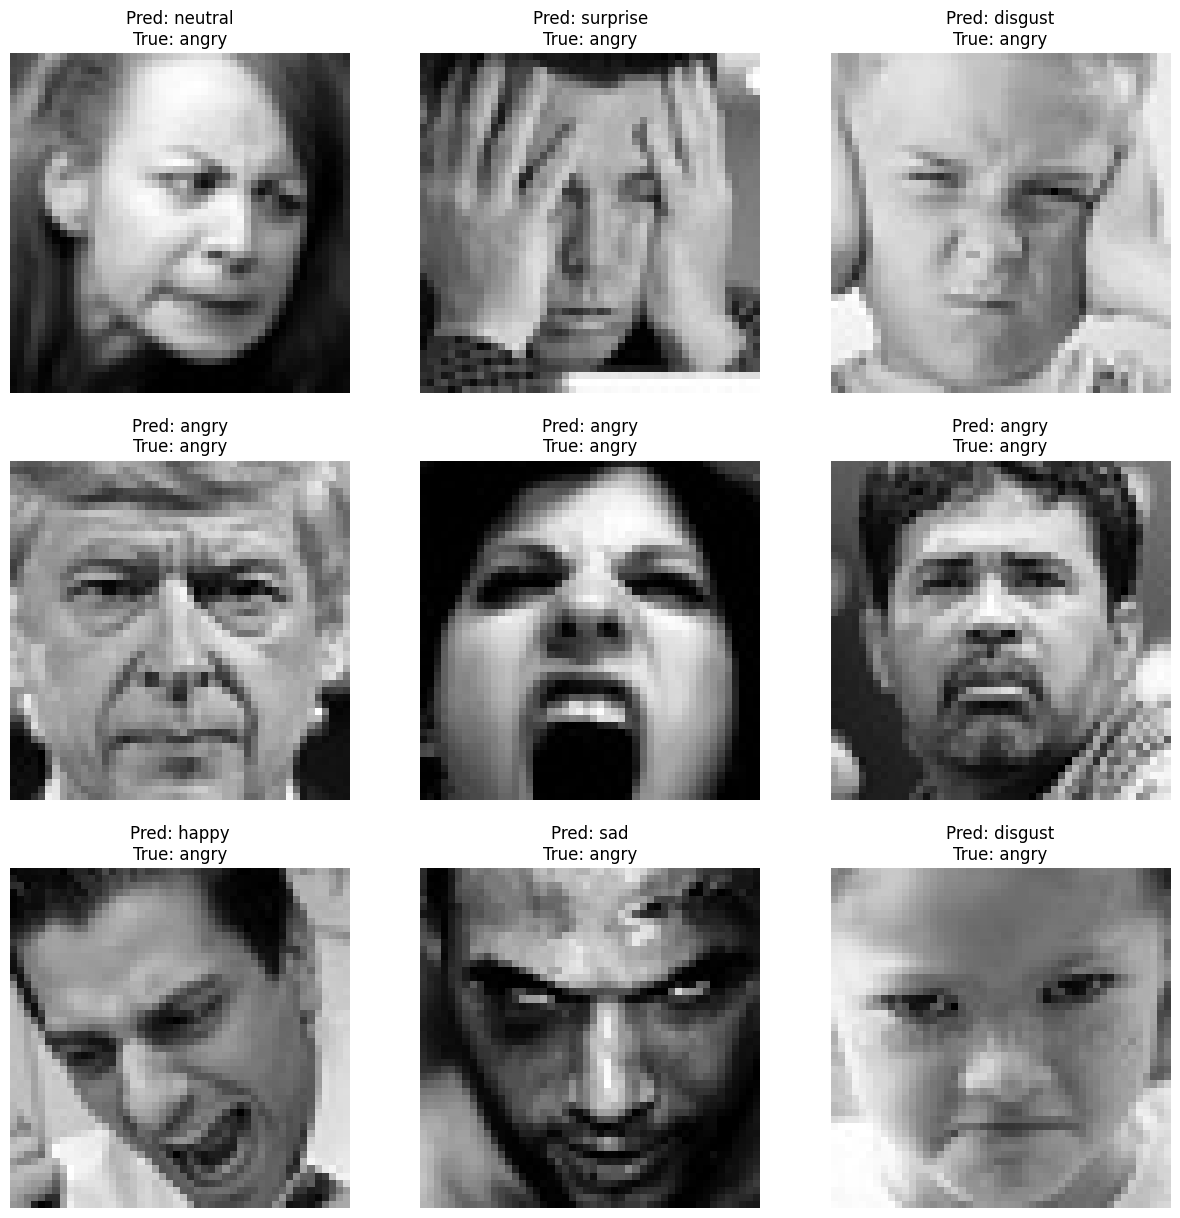

In [ ]:
# Display some test images with predictions
def visualize_predictions(test_generator, model, class_names, num_images=9):
    images, labels = next(test_generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}")
        plt.axis('off')
    plt.show()

# Call the function to visualize predictions
visualize_predictions(test_generator, model, class_names)



---



---



In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('fer2013_emotion_model.h5')
print("Model loaded successfully!")

# Define class names (ensure this matches the training setup)
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Load and preprocess a new image
img_path = '/content/fer2013/fer2013/test/fear/1008.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_emotion = class_names[predicted_class]

print(f"Predicted Emotion: {predicted_emotion}")

Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
Predicted Emotion: sad
